# Calculating features

Training a neural network from scratch takes a lot of computational resources and enough, roughly balanced training data. Alternatively, one can use a __pretrained__ neural network and use it as a __feature extractor__.
`Keras` offers multiple pretrained models, that are mostly trained on imagenet, a database of natural images from 1000 classes.

This notebook loads such a model, removes its classification layer and adds a pooling layer such that the output is a feature vector instead of a classification result. These features are later going to be classified with a "non-deep" approach, such as an SVM or RF.

A set of features is stored as Pandas Dataframe with columns `id`, `label` and `features`. 

Again, __every region is treated separately__, i.e. gets its own dataframe of features and its own pickle file.
This might seem a little impractical and clumsy but has two advantages in this context:

1. Feature calculation is of course faster on smaller subsets. When trying new models or new parameters, features can be computed on a region with few roofs first.
2. Datasets are have different classification "difficulties". E.g. `mixco_3` is a small set that has no "incomplete" or "other" samples and only correctly labeled data. Thus, the pipeline can be tested on easy and more difficult sets.

In [20]:
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50 #--- good
from keras.applications.resnet50 import preprocess_input
#from keras.applications.inception_v3 import InceptionV3
#from keras.applications.inception_v3 import preprocess_input
#from keras.applications.vgg16 import VGG16 --- ok-ish
#from keras.applications.vgg16 import preprocess_input
#from keras.applications.xception import Xception --- bad
#from keras.applications.xception import preprocess_input
#from keras.applications.inception_resnet_v2 import InceptionResNetV2 ---ok-ish
#from keras.applications.inception_resnet_v2 import preprocess_input
#from keras.applications.nasnet import NASNetLarge --- bad
#from keras.applications.nasnet import preprocess_input
#from keras.applications.densenet import DenseNet201 #--- good
#from keras.applications.densenet import preprocess_input

import numpy as np
import pandas as pd
from os.path import join
import os

import matplotlib.pyplot as plt

In [21]:
regions = ['borde_rural', 'borde_soacha', 'mixco_1_and_ebenezer', 'mixco_3']

In [22]:
region = 'borde_rural'
train_dir = join('..', '..', 'data', 'data2', region, 'roofs_train')
test_dir = join('..', '..', 'data', 'data2', region, 'roofs_test')
materials = {'concrete_cement':0, 'healthy_metal':1, 'incomplete':2, 'irregular_metal':3, 'other':4}

Use a pretrained network to compute features from the images, which are later classified. Import the model from the Keras library and remove the top layer by setting `include_top=False`. The last layer is pooled such that we get outputs of size 1x2048 (for ResNet50) instead of 7x7x2048. The pooling method `'max'` is chosen empirically.

## 1. Load the model

In [23]:
model = ResNet50(weights='imagenet', include_top=False, pooling='avg', classes=1000)
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
___________________________________________________________________________________________

## 2. Calculate features on the training data

The preprocessed data is stored in such a way, that every region has their own folder, that contains a subfolder defined as `train_dir` above. This folder again is subdivided by material. Images carry their `id` as filename.

Traverse all images in their corresponding folders which indicate the material and use `model.predict()` to get the features.

In [24]:
def calculate_features_train(train_dir):
    
    # Initialize a dataframe for the features    
    columns = ['id', 'features', 'label']
    df_features = pd.DataFrame(columns=columns)
    
    data = []

    # Walk through all images
    for material in materials.keys():
        material_fp = join(train_dir, material)
        for root, dirs, files in os.walk(material_fp):
            for file in files:
                img_fp = join(material_fp, file)
                label = materials[material]
                id = file.split('.')[0]
                print(id, "labeled as", material, ":", label)

                # Pad if size is too small, preprocess
                img = image.load_img(img_fp, target_size=(224, 224))
                img_data = image.img_to_array(img)
                #plt.imshow(img_data, vmin=0, vmax=1)
                img_data = np.expand_dims(img_data, axis=0)
                img_data = preprocess_input(img_data)

                # Compute features 
                features = model.predict(img_data)
                features_np = np.array(features).flatten()

                data.append({'id': id ,
                             'features': features_np,
                             'label': label})
                #df_features = df_features.append({'id': id ,
                #                                  'features': resnet50_feature_np,
                #                                  'label': label}, ignore_index=True)
    
    df_features = pd.DataFrame(data)
    return df_features

The results are stored in a dataframe as shown below and saved to disk as a pickle file.

In [25]:
print(train_dir)

../../data/data2/borde_rural/roofs_train


In [26]:
features_train = calculate_features_train(train_dir)

7a37c004 labeled as concrete_cement : 0
7a43cf34 labeled as concrete_cement : 0
7a2beb9e labeled as concrete_cement : 0
7a30cd44 labeled as concrete_cement : 0
7a26b840 labeled as concrete_cement : 0
7a1e26e4 labeled as concrete_cement : 0
7a3d3c5a labeled as concrete_cement : 0
7a21585a labeled as concrete_cement : 0
7a33a1ea labeled as concrete_cement : 0
7a3e0c0c labeled as concrete_cement : 0
7a28c34c labeled as concrete_cement : 0
7a324c46 labeled as concrete_cement : 0
7a3bd130 labeled as concrete_cement : 0
7a3d60ea labeled as concrete_cement : 0
7a371474 labeled as concrete_cement : 0
7a42c936 labeled as concrete_cement : 0
7a313a54 labeled as concrete_cement : 0
7a3c5a2e labeled as concrete_cement : 0
7a2c0728 labeled as concrete_cement : 0
7a1c6d7c labeled as concrete_cement : 0
7a1f76d4 labeled as concrete_cement : 0
7a2c28c0 labeled as concrete_cement : 0
7a24ba22 labeled as concrete_cement : 0
7a3f6476 labeled as concrete_cement : 0
7a228aea labeled as concrete_cement : 0


7a245cf8 labeled as concrete_cement : 0
7a3435ba labeled as concrete_cement : 0
7a21973e labeled as concrete_cement : 0
7a3a09ae labeled as concrete_cement : 0
7a441c96 labeled as concrete_cement : 0
7a1eb73a labeled as concrete_cement : 0
7a40adc2 labeled as concrete_cement : 0
7a32798c labeled as concrete_cement : 0
7a3a7768 labeled as concrete_cement : 0
7a4042ba labeled as concrete_cement : 0
7a268118 labeled as concrete_cement : 0
7a3da64a labeled as concrete_cement : 0
7a1d4580 labeled as healthy_metal : 1
7a42e056 labeled as healthy_metal : 1
7a3288be labeled as healthy_metal : 1
7a2c0ef8 labeled as healthy_metal : 1
7a4048fa labeled as healthy_metal : 1
7a304ae0 labeled as healthy_metal : 1
7a32d2e2 labeled as healthy_metal : 1
7a1d54b2 labeled as healthy_metal : 1
7a44bfd4 labeled as healthy_metal : 1
7a26ccfe labeled as healthy_metal : 1
7a2d3e72 labeled as healthy_metal : 1
7a2de37c labeled as healthy_metal : 1
7a3af3c8 labeled as healthy_metal : 1
7a21c34e labeled as health

7a2866ea labeled as healthy_metal : 1
7a1ee1e2 labeled as healthy_metal : 1
7a23a4fc labeled as healthy_metal : 1
7a2b5c1a labeled as healthy_metal : 1
7a4047ba labeled as healthy_metal : 1
7a40026e labeled as healthy_metal : 1
7a3579ca labeled as healthy_metal : 1
7a253f1a labeled as healthy_metal : 1
7a2085ba labeled as healthy_metal : 1
7a413bd4 labeled as healthy_metal : 1
7a38acc6 labeled as healthy_metal : 1
7a201f1c labeled as healthy_metal : 1
7a2906a4 labeled as healthy_metal : 1
7a1fe7fe labeled as healthy_metal : 1
7a2182c6 labeled as healthy_metal : 1
7a3ddf48 labeled as healthy_metal : 1
7a283846 labeled as healthy_metal : 1
7a43b562 labeled as healthy_metal : 1
7a27f0e8 labeled as healthy_metal : 1
7a34c994 labeled as healthy_metal : 1
7a25d772 labeled as healthy_metal : 1
7a2ee7a4 labeled as healthy_metal : 1
7a29c2f6 labeled as healthy_metal : 1
7a3bf55c labeled as healthy_metal : 1
7a35c358 labeled as healthy_metal : 1
7a3a0dbe labeled as healthy_metal : 1
7a22e86e lab

7a2e8eee labeled as healthy_metal : 1
7a28b1c2 labeled as healthy_metal : 1
7a1dfdcc labeled as healthy_metal : 1
7a3577b8 labeled as healthy_metal : 1
7a27d86a labeled as healthy_metal : 1
7a3bd3ec labeled as healthy_metal : 1
7a3d7490 labeled as healthy_metal : 1
7a3fc0c4 labeled as healthy_metal : 1
7a2f1364 labeled as healthy_metal : 1
7a42dd68 labeled as healthy_metal : 1
7a431b0c labeled as healthy_metal : 1
7a29f42e labeled as healthy_metal : 1
7a4120ea labeled as healthy_metal : 1
7a3894c0 labeled as healthy_metal : 1
7a369648 labeled as healthy_metal : 1
7a3a87c6 labeled as healthy_metal : 1
7a3cbafa labeled as healthy_metal : 1
7a3350dc labeled as healthy_metal : 1
7a2b6340 labeled as healthy_metal : 1
7a404828 labeled as healthy_metal : 1
7a3e5c5c labeled as healthy_metal : 1
7a21d032 labeled as healthy_metal : 1
7a4081da labeled as healthy_metal : 1
7a406bc8 labeled as healthy_metal : 1
7a4065d8 labeled as healthy_metal : 1
7a357394 labeled as healthy_metal : 1
7a3cbc3a lab

7a2f5662 labeled as healthy_metal : 1
7a367b22 labeled as healthy_metal : 1
7a3debf0 labeled as healthy_metal : 1
7a2855c4 labeled as healthy_metal : 1
7a282fae labeled as healthy_metal : 1
7a443c9e labeled as healthy_metal : 1
7a3384a8 labeled as healthy_metal : 1
7a3780ee labeled as healthy_metal : 1
7a286898 labeled as healthy_metal : 1
7a35f18e labeled as healthy_metal : 1
7a21c61e labeled as healthy_metal : 1
7a3a95ea labeled as healthy_metal : 1
7a42885e labeled as healthy_metal : 1
7a1dabec labeled as healthy_metal : 1
7a29adac labeled as healthy_metal : 1
7a1c88e8 labeled as healthy_metal : 1
7a3d3002 labeled as healthy_metal : 1
7a222ee2 labeled as healthy_metal : 1
7a1da7e6 labeled as healthy_metal : 1
7a3cf772 labeled as healthy_metal : 1
7a1e6410 labeled as healthy_metal : 1
7a1d7c94 labeled as healthy_metal : 1
7a3e0cde labeled as healthy_metal : 1
7a210e7c labeled as healthy_metal : 1
7a3eb4ae labeled as healthy_metal : 1
7a2b4f0e labeled as healthy_metal : 1
7a2a3146 lab

7a22c014 labeled as healthy_metal : 1
7a25b76a labeled as healthy_metal : 1
7a404a44 labeled as healthy_metal : 1
7a2415b8 labeled as healthy_metal : 1
7a3a5f58 labeled as healthy_metal : 1
7a2f935c labeled as healthy_metal : 1
7a3ab462 labeled as healthy_metal : 1
7a44a170 labeled as healthy_metal : 1
7a41ede0 labeled as healthy_metal : 1
7a3008aa labeled as healthy_metal : 1
7a2e01a4 labeled as healthy_metal : 1
7a22bede labeled as healthy_metal : 1
7a2f65d0 labeled as healthy_metal : 1
7a42e34e labeled as healthy_metal : 1
7a231d3e labeled as healthy_metal : 1
7a3d9966 labeled as healthy_metal : 1
7a270250 labeled as healthy_metal : 1
7a38d124 labeled as healthy_metal : 1
7a442a92 labeled as healthy_metal : 1
7a1f7a12 labeled as healthy_metal : 1
7a1e6be0 labeled as healthy_metal : 1
7a287fb8 labeled as healthy_metal : 1
7a335280 labeled as healthy_metal : 1
7a2ad362 labeled as healthy_metal : 1
7a2fc476 labeled as healthy_metal : 1
7a2f51da labeled as healthy_metal : 1
7a425d02 lab

7a3a9c34 labeled as healthy_metal : 1
7a2af7ac labeled as healthy_metal : 1
7a3b6826 labeled as healthy_metal : 1
7a400e3a labeled as healthy_metal : 1
7a1ee106 labeled as healthy_metal : 1
7a39680a labeled as healthy_metal : 1
7a3d721a labeled as healthy_metal : 1
7a3904fa labeled as healthy_metal : 1
7a3b33e2 labeled as healthy_metal : 1
7a30eafe labeled as healthy_metal : 1
7a2e6964 labeled as healthy_metal : 1
7a386d38 labeled as healthy_metal : 1
7a204a50 labeled as healthy_metal : 1
7a325736 labeled as healthy_metal : 1
7a25b044 labeled as healthy_metal : 1
7a3a9eaa labeled as healthy_metal : 1
7a2cfcaa labeled as healthy_metal : 1
7a24b644 labeled as healthy_metal : 1
7a2aa68a labeled as healthy_metal : 1
7a3b7f0a labeled as healthy_metal : 1
7a3aafd0 labeled as healthy_metal : 1
7a334d58 labeled as healthy_metal : 1
7a41a4f2 labeled as healthy_metal : 1
7a3f388e labeled as healthy_metal : 1
7a36fbb0 labeled as healthy_metal : 1
7a2d78f6 labeled as healthy_metal : 1
7a21b67e lab

7a41f538 labeled as healthy_metal : 1
7a36214a labeled as healthy_metal : 1
7a3abbe2 labeled as healthy_metal : 1
7a2f45c8 labeled as healthy_metal : 1
7a2db640 labeled as healthy_metal : 1
7a213226 labeled as healthy_metal : 1
7a3ddb9c labeled as healthy_metal : 1
7a2d9fe8 labeled as healthy_metal : 1
7a3f39ec labeled as healthy_metal : 1
7a306520 labeled as healthy_metal : 1
7a20ab30 labeled as healthy_metal : 1
7a39b0da labeled as healthy_metal : 1
7a24e51a labeled as healthy_metal : 1
7a39f860 labeled as healthy_metal : 1
7a334e98 labeled as healthy_metal : 1
7a4166d6 labeled as healthy_metal : 1
7a2049ec labeled as healthy_metal : 1
7a202868 labeled as healthy_metal : 1
7a24a97e labeled as healthy_metal : 1
7a2730ae labeled as healthy_metal : 1
7a1ca3b4 labeled as healthy_metal : 1
7a202b9c labeled as healthy_metal : 1
7a2f5f90 labeled as healthy_metal : 1
7a1e164a labeled as healthy_metal : 1
7a42906a labeled as healthy_metal : 1
7a1f39bc labeled as healthy_metal : 1
7a311696 lab

7a1ea0c4 labeled as healthy_metal : 1
7a307416 labeled as healthy_metal : 1
7a22903a labeled as healthy_metal : 1
7a301bd8 labeled as healthy_metal : 1
7a295dde labeled as healthy_metal : 1
7a1d0bec labeled as healthy_metal : 1
7a21b41c labeled as healthy_metal : 1
7a43be0e labeled as healthy_metal : 1
7a44b70a labeled as healthy_metal : 1
7a29f64a labeled as healthy_metal : 1
7a250324 labeled as healthy_metal : 1
7a233b2a labeled as healthy_metal : 1
7a31421a labeled as healthy_metal : 1
7a33a5a0 labeled as healthy_metal : 1
7a32a114 labeled as healthy_metal : 1
7a3d7706 labeled as healthy_metal : 1
7a220822 labeled as healthy_metal : 1
7a2c4260 labeled as healthy_metal : 1
7a3c6b5e labeled as healthy_metal : 1
7a344a28 labeled as healthy_metal : 1
7a2fbb02 labeled as healthy_metal : 1
7a3e73e0 labeled as healthy_metal : 1
7a29a79e labeled as healthy_metal : 1
7a3e0fc2 labeled as healthy_metal : 1
7a2fff7c labeled as healthy_metal : 1
7a3c298c labeled as healthy_metal : 1
7a1eebc4 lab

7a36d1bc labeled as healthy_metal : 1
7a3007ce labeled as healthy_metal : 1
7a38ed4e labeled as healthy_metal : 1
7a3d9ec0 labeled as healthy_metal : 1
7a1f738c labeled as healthy_metal : 1
7a1e8b84 labeled as healthy_metal : 1
7a366998 labeled as healthy_metal : 1
7a3cd44a labeled as healthy_metal : 1
7a35795c labeled as healthy_metal : 1
7a2d7266 labeled as healthy_metal : 1
7a26b4e4 labeled as healthy_metal : 1
7a1dd978 labeled as healthy_metal : 1
7a23a25e labeled as healthy_metal : 1
7a3d8066 labeled as healthy_metal : 1
7a1d0052 labeled as healthy_metal : 1
7a40bf4c labeled as healthy_metal : 1
7a263032 labeled as healthy_metal : 1
7a3781c0 labeled as healthy_metal : 1
7a43e208 labeled as healthy_metal : 1
7a34b846 labeled as healthy_metal : 1
7a25a93c labeled as healthy_metal : 1
7a315ec6 labeled as healthy_metal : 1
7a32ef70 labeled as healthy_metal : 1
7a1ef704 labeled as healthy_metal : 1
7a2eb78e labeled as healthy_metal : 1
7a333b74 labeled as healthy_metal : 1
7a1dbaec lab

7a2ed264 labeled as healthy_metal : 1
7a3d195a labeled as healthy_metal : 1
7a2bb0d4 labeled as healthy_metal : 1
7a3d0e92 labeled as healthy_metal : 1
7a32ab50 labeled as healthy_metal : 1
7a296586 labeled as healthy_metal : 1
7a31c4c4 labeled as healthy_metal : 1
7a2e503c labeled as healthy_metal : 1
7a1d384c labeled as healthy_metal : 1
7a3cd5f8 labeled as healthy_metal : 1
7a2f1724 labeled as healthy_metal : 1
7a2ccfd2 labeled as healthy_metal : 1
7a2e1158 labeled as healthy_metal : 1
7a3f03d2 labeled as healthy_metal : 1
7a3639aa labeled as healthy_metal : 1
7a2e343a labeled as healthy_metal : 1
7a21ac7e labeled as healthy_metal : 1
7a38240e labeled as healthy_metal : 1
7a2aa982 labeled as healthy_metal : 1
7a404328 labeled as healthy_metal : 1
7a3d77d8 labeled as healthy_metal : 1
7a43027a labeled as healthy_metal : 1
7a1d8824 labeled as healthy_metal : 1
7a3d355c labeled as healthy_metal : 1
7a3883ea labeled as healthy_metal : 1
7a3fb8f4 labeled as healthy_metal : 1
7a331a86 lab

7a309e00 labeled as healthy_metal : 1
7a380b54 labeled as healthy_metal : 1
7a349f28 labeled as healthy_metal : 1
7a2d1384 labeled as healthy_metal : 1
7a271164 labeled as healthy_metal : 1
7a387aa8 labeled as healthy_metal : 1
7a3b7fdc labeled as healthy_metal : 1
7a2217ae labeled as healthy_metal : 1
7a2526ba labeled as healthy_metal : 1
7a2f1b48 labeled as healthy_metal : 1
7a1cfada labeled as healthy_metal : 1
7a2edc3c labeled as healthy_metal : 1
7a29a94c labeled as healthy_metal : 1
7a276ae2 labeled as healthy_metal : 1
7a24df98 labeled as healthy_metal : 1
7a3e8e0c labeled as healthy_metal : 1
7a3ac5e2 labeled as healthy_metal : 1
7a2de1ce labeled as healthy_metal : 1
7a378436 labeled as healthy_metal : 1
7a2efb04 labeled as healthy_metal : 1
7a2c9468 labeled as healthy_metal : 1
7a40a930 labeled as healthy_metal : 1
7a3a35c8 labeled as healthy_metal : 1
7a27ccbc labeled as healthy_metal : 1
7a403c7a labeled as healthy_metal : 1
7a333822 labeled as healthy_metal : 1
7a2c63bc lab

7a3ef22a labeled as healthy_metal : 1
7a1cb868 labeled as healthy_metal : 1
7a2a6832 labeled as healthy_metal : 1
7a219db0 labeled as healthy_metal : 1
7a404e7c labeled as healthy_metal : 1
7a3e8704 labeled as healthy_metal : 1
7a35991e labeled as healthy_metal : 1
7a375ad8 labeled as healthy_metal : 1
7a4223dc labeled as healthy_metal : 1
7a209d0c labeled as healthy_metal : 1
7a34de2a labeled as healthy_metal : 1
7a2d520e labeled as incomplete : 2
7a43287c labeled as incomplete : 2
7a36a606 labeled as incomplete : 2
7a399514 labeled as incomplete : 2
7a411334 labeled as incomplete : 2
7a215454 labeled as incomplete : 2
7a2f2174 labeled as incomplete : 2
7a1e2dce labeled as incomplete : 2
7a2e78f0 labeled as incomplete : 2
7a3e3150 labeled as incomplete : 2
7a34e65e labeled as incomplete : 2
7a25dc04 labeled as incomplete : 2
7a3c1c4e labeled as incomplete : 2
7a3f1a2a labeled as incomplete : 2
7a361be6 labeled as incomplete : 2
7a3450cc labeled as incomplete : 2
7a43ff86 labeled as in

7a439e10 labeled as incomplete : 2
7a2d768a labeled as incomplete : 2
7a311196 labeled as incomplete : 2
7a2cb75e labeled as incomplete : 2
7a3d8d22 labeled as incomplete : 2
7a3ba5de labeled as incomplete : 2
7a26936a labeled as incomplete : 2
7a3b80b8 labeled as incomplete : 2
7a21a742 labeled as incomplete : 2
7a2482b4 labeled as incomplete : 2
7a2d39e0 labeled as incomplete : 2
7a2786ee labeled as incomplete : 2
7a24c0d0 labeled as incomplete : 2
7a2ca084 labeled as incomplete : 2
7a2fad6a labeled as incomplete : 2
7a36869e labeled as incomplete : 2
7a1e9548 labeled as incomplete : 2
7a298624 labeled as incomplete : 2
7a3b898c labeled as incomplete : 2
7a250fea labeled as incomplete : 2
7a200054 labeled as incomplete : 2
7a2a8e2a labeled as irregular_metal : 3
7a35beda labeled as irregular_metal : 3
7a297148 labeled as irregular_metal : 3
7a260fd0 labeled as irregular_metal : 3
7a41fa1a labeled as irregular_metal : 3
7a36b4d4 labeled as irregular_metal : 3
7a3fb962 labeled as irreg

7a3a581e labeled as irregular_metal : 3
7a2a0b94 labeled as irregular_metal : 3
7a3bc6b8 labeled as irregular_metal : 3
7a3c5614 labeled as irregular_metal : 3
7a21f710 labeled as irregular_metal : 3
7a1f00a0 labeled as irregular_metal : 3
7a26ffd0 labeled as irregular_metal : 3
7a334e2a labeled as irregular_metal : 3
7a397bc4 labeled as irregular_metal : 3
7a253e3e labeled as irregular_metal : 3
7a3c27de labeled as irregular_metal : 3
7a2002ca labeled as irregular_metal : 3
7a25e2b2 labeled as irregular_metal : 3
7a38f0a0 labeled as irregular_metal : 3
7a26c038 labeled as irregular_metal : 3
7a3a54cc labeled as irregular_metal : 3
7a3cd378 labeled as irregular_metal : 3
7a3b2bea labeled as irregular_metal : 3
7a1ec950 labeled as irregular_metal : 3
7a42b63a labeled as irregular_metal : 3
7a326c44 labeled as irregular_metal : 3
7a1e912e labeled as irregular_metal : 3
7a1c92a2 labeled as irregular_metal : 3
7a1e1d34 labeled as irregular_metal : 3
7a343e84 labeled as irregular_metal : 3


7a21bfac labeled as irregular_metal : 3
7a1e7b3a labeled as irregular_metal : 3
7a22cad2 labeled as irregular_metal : 3
7a312aaa labeled as irregular_metal : 3
7a442542 labeled as irregular_metal : 3
7a3d1a9a labeled as irregular_metal : 3
7a262d44 labeled as irregular_metal : 3
7a208b50 labeled as irregular_metal : 3
7a324732 labeled as irregular_metal : 3
7a32d904 labeled as irregular_metal : 3
7a329e94 labeled as irregular_metal : 3
7a1d913e labeled as irregular_metal : 3
7a25e99c labeled as irregular_metal : 3
7a3df492 labeled as irregular_metal : 3
7a2bb214 labeled as irregular_metal : 3
7a4186d4 labeled as irregular_metal : 3
7a443a96 labeled as irregular_metal : 3
7a212db2 labeled as irregular_metal : 3
7a1e4606 labeled as irregular_metal : 3
7a26c83a labeled as irregular_metal : 3
7a3f3564 labeled as irregular_metal : 3
7a39c08e labeled as irregular_metal : 3
7a44b62e labeled as irregular_metal : 3
7a3c40c0 labeled as irregular_metal : 3
7a36a0c0 labeled as irregular_metal : 3


7a329804 labeled as irregular_metal : 3
7a3c7694 labeled as irregular_metal : 3
7a2ec29c labeled as irregular_metal : 3
7a36b1a0 labeled as irregular_metal : 3
7a1ec662 labeled as irregular_metal : 3
7a23545c labeled as irregular_metal : 3
7a3ca646 labeled as irregular_metal : 3
7a2dd15c labeled as irregular_metal : 3
7a350b34 labeled as irregular_metal : 3
7a1e51c8 labeled as irregular_metal : 3
7a3af652 labeled as irregular_metal : 3
7a1ea880 labeled as irregular_metal : 3
7a268334 labeled as irregular_metal : 3
7a219d4c labeled as irregular_metal : 3
7a32da44 labeled as irregular_metal : 3
7a22f368 labeled as irregular_metal : 3
7a22703c labeled as irregular_metal : 3
7a24c9ae labeled as irregular_metal : 3
7a2187f8 labeled as irregular_metal : 3
7a3ea72a labeled as irregular_metal : 3
7a32a948 labeled as irregular_metal : 3
7a34bb84 labeled as irregular_metal : 3
7a3c3d6e labeled as irregular_metal : 3
7a445710 labeled as irregular_metal : 3
7a206904 labeled as irregular_metal : 3


7a36dfc2 labeled as irregular_metal : 3
7a1d4062 labeled as irregular_metal : 3
7a277b36 labeled as irregular_metal : 3
7a2854f2 labeled as irregular_metal : 3
7a25c53e labeled as irregular_metal : 3
7a41b672 labeled as irregular_metal : 3
7a1e529a labeled as irregular_metal : 3
7a419908 labeled as irregular_metal : 3
7a3671a4 labeled as irregular_metal : 3
7a3d5ee2 labeled as irregular_metal : 3
7a3afaf8 labeled as irregular_metal : 3
7a204bf4 labeled as irregular_metal : 3
7a35a620 labeled as irregular_metal : 3
7a2cd8a6 labeled as irregular_metal : 3
7a2daa74 labeled as irregular_metal : 3
7a28f830 labeled as irregular_metal : 3
7a28a24a labeled as irregular_metal : 3
7a3308f2 labeled as irregular_metal : 3
7a397b56 labeled as irregular_metal : 3
7a21761e labeled as irregular_metal : 3
7a40e152 labeled as irregular_metal : 3
7a35ae68 labeled as irregular_metal : 3
7a3eadba labeled as irregular_metal : 3
7a37beb0 labeled as irregular_metal : 3
7a412018 labeled as irregular_metal : 3


7a42af96 labeled as irregular_metal : 3
7a3a509e labeled as irregular_metal : 3
7a3c7054 labeled as irregular_metal : 3
7a2d9a98 labeled as irregular_metal : 3
7a3861f8 labeled as irregular_metal : 3
7a1cf940 labeled as irregular_metal : 3
7a444c16 labeled as irregular_metal : 3
7a3da8c0 labeled as irregular_metal : 3
7a2102d8 labeled as irregular_metal : 3
7a3f4b6c labeled as irregular_metal : 3
7a43dcae labeled as irregular_metal : 3
7a1e7fae labeled as irregular_metal : 3
7a40d75c labeled as irregular_metal : 3
7a21cd58 labeled as irregular_metal : 3
7a3a72cc labeled as irregular_metal : 3
7a38cd5a labeled as irregular_metal : 3
7a236a1e labeled as irregular_metal : 3
7a20bd50 labeled as irregular_metal : 3
7a26aa3a labeled as irregular_metal : 3
7a397de0 labeled as irregular_metal : 3
7a2b315e labeled as irregular_metal : 3
7a32e0c0 labeled as irregular_metal : 3
7a2d45fc labeled as irregular_metal : 3
7a21bee4 labeled as irregular_metal : 3
7a1e94da labeled as irregular_metal : 3


7a21c952 labeled as irregular_metal : 3
7a2fb184 labeled as irregular_metal : 3
7a3d797c labeled as irregular_metal : 3
7a32b0a0 labeled as irregular_metal : 3
7a3518d6 labeled as irregular_metal : 3
7a29033e labeled as irregular_metal : 3
7a1e8224 labeled as irregular_metal : 3
7a3325bc labeled as irregular_metal : 3
7a43195e labeled as irregular_metal : 3
7a3159da labeled as irregular_metal : 3
7a262b28 labeled as irregular_metal : 3
7a1eadda labeled as irregular_metal : 3
7a258466 labeled as irregular_metal : 3
7a309a9a labeled as irregular_metal : 3
7a3e9708 labeled as irregular_metal : 3
7a3932b8 labeled as irregular_metal : 3
7a3ca9a2 labeled as irregular_metal : 3
7a397804 labeled as irregular_metal : 3
7a277bcc labeled as irregular_metal : 3
7a365b06 labeled as irregular_metal : 3
7a27ba24 labeled as irregular_metal : 3
7a240122 labeled as irregular_metal : 3
7a3edb8c labeled as irregular_metal : 3
7a2ebfc2 labeled as irregular_metal : 3
7a222758 labeled as irregular_metal : 3


7a243570 labeled as irregular_metal : 3
7a333476 labeled as irregular_metal : 3
7a345c02 labeled as irregular_metal : 3
7a236334 labeled as irregular_metal : 3
7a2bf814 labeled as irregular_metal : 3
7a2c54f8 labeled as irregular_metal : 3
7a2b30f0 labeled as irregular_metal : 3
7a4429c0 labeled as irregular_metal : 3
7a348db2 labeled as irregular_metal : 3
7a3b0746 labeled as irregular_metal : 3
7a400a02 labeled as irregular_metal : 3
7a31ca82 labeled as irregular_metal : 3
7a33a820 labeled as irregular_metal : 3
7a2603b4 labeled as irregular_metal : 3
7a43a2ac labeled as irregular_metal : 3
7a3ce610 labeled as irregular_metal : 3
7a2e7440 labeled as irregular_metal : 3
7a3dafb4 labeled as irregular_metal : 3
7a1e17ee labeled as irregular_metal : 3
7a396738 labeled as irregular_metal : 3
7a336414 labeled as irregular_metal : 3
7a285920 labeled as irregular_metal : 3
7a3201e6 labeled as irregular_metal : 3
7a3bb114 labeled as irregular_metal : 3
7a1e55d8 labeled as irregular_metal : 3


In [27]:
features_train.head()

,id,features,label
0,7a37c004,"[0.250077, 1.1017908, 0.37730786, 0.0062653874...",0
1,7a43cf34,"[0.6316467, 0.5006278, 0.29867697, 0.004724741...",0
2,7a2beb9e,"[0.0, 1.594308, 0.4789346, 0.033646423, 0.0, 0...",0
3,7a30cd44,"[0.03374534, 0.59143084, 0.051606055, 0.095690...",0
4,7a26b840,"[0.22346756, 1.1884248, 0.009053908, 0.0141086...",0


In [28]:
len(features_train.features[0])

2048

Save feature frames as pickles

In [29]:
import pickle
from os import makedirs
from os.path import exists

pickle_path = join('..', '..', 'pickles')
if not exists(pickle_path):
    makedirs(pickle_path)

with open(join(pickle_path, 'resnet50_avg_features_' + region + '_train.pkl' ), 'wb') as f:
    pickle.dump(features_train, f)

### 2.1 Visualize discriminativeness

In order to visualize how well the extracted features discriminate the classes, the dimensionality of the feature vector can be reduced to 2 using the tSNE (https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)

In [30]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [31]:
def plot_tSNE(features, labels=None, number_of_materials=5, title='default_title', path='.'):
    if labels is None:
        labels = np.zeros((features.shape[0]))

    tsne_features = TSNE(n_components=2).fit_transform(features)

    # define the colormap
    cmap = plt.cm.jet
    # extract all colors from the .jet map
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # create the new map
    cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

    # define the bins and normalize
    bounds = np.linspace(0, number_of_materials, number_of_materials + 1)
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
    
    print(tsne_features.shape)

    plt.figure()
    plt.title(title)
    scat = plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=labels, cmap=cmap, norm=norm)
    cb = plt.colorbar(scat, spacing='proportional', ticks=bounds)
    plt.savefig(join(path, title+'.png'))

Convert features within the dataframe to a single matrix

In [32]:
feat_matrix = features_train['features'].to_numpy()
feat_matrix = np.column_stack(feat_matrix).transpose()

labels = features_train['label'].to_numpy()

(4353, 2)


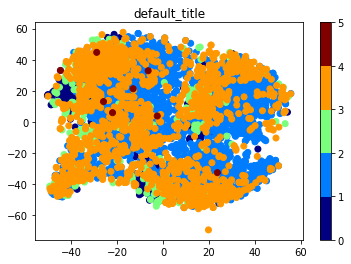

In [14]:
results_dir = join('..', '..', 'results')
plot_tSNE(feat_matrix, labels, path=results_dir)

## 2. Calculate features on the test data


This procedure is similar as for the training data, except that we do not know the labels and the folder with test images is not subdivided by material

In [33]:
def calculate_features_test(test_dir):
    
    # Initialize a dataframe for the features    
    columns = ['id', 'features']
    df_features = pd.DataFrame(columns=columns)

    # Walk through all images
    for root, dirs, files in os.walk(test_dir):
        for file in files:
            img_fp = join(root, file)
            id = file.split('.')[0]
            print("Calculate features for", id)

            # Pad if size is too small, preprocess
            img = image.load_img(img_fp, target_size=(224, 224))
            img_data = image.img_to_array(img)
            img_data = np.expand_dims(img_data, axis=0)
            img_data = preprocess_input(img_data)

            # Compute features 
            features = model.predict(img_data)
            features_np = np.array(features).flatten()

            df_features = df_features.append({'id': id ,
                                              'features': features_np},
                                             ignore_index=True)

    return df_features

In [34]:
features_test = calculate_features_test(test_dir)

Calculate features for 7a4ca23a
Calculate features for 7a4a091c
Calculate features for 7a4aba6a
Calculate features for 7a500c04
Calculate features for 7a46f132
Calculate features for 7a4c1ba8
Calculate features for 7a46f614
Calculate features for 7a495af8
Calculate features for 7a4d8a7e
Calculate features for 7a44da50
Calculate features for 7a517ee0
Calculate features for 7a4f76ea
Calculate features for 7a475884
Calculate features for 7a45e166
Calculate features for 7a49e298
Calculate features for 7a511ef0
Calculate features for 7a4e92a2
Calculate features for 7a51dff2
Calculate features for 7a4f9dfa
Calculate features for 7a4d1698
Calculate features for 7a497eac
Calculate features for 7a4ab100
Calculate features for 7a487d68
Calculate features for 7a4fbe20
Calculate features for 7a4f719a
Calculate features for 7a4e52d8
Calculate features for 7a4d6e72
Calculate features for 7a460510
Calculate features for 7a45c096
Calculate features for 7a4e60ac
Calculate features for 7a510848
Calculat

Calculate features for 7a4d19e0
Calculate features for 7a51eab0
Calculate features for 7a4683c8
Calculate features for 7a4c42cc
Calculate features for 7a51a21c
Calculate features for 7a4812c4
Calculate features for 7a47adac
Calculate features for 7a4e297a
Calculate features for 7a48e6a4
Calculate features for 7a4f73ac
Calculate features for 7a4ec72c
Calculate features for 7a481620
Calculate features for 7a4c425e
Calculate features for 7a4cbed2
Calculate features for 7a4f85fe
Calculate features for 7a502eb4
Calculate features for 7a491e08
Calculate features for 7a4b321a
Calculate features for 7a5006be
Calculate features for 7a450df4
Calculate features for 7a4c1e14
Calculate features for 7a4754b0
Calculate features for 7a50ff38
Calculate features for 7a4af156
Calculate features for 7a44f0d0
Calculate features for 7a4e3758
Calculate features for 7a4f5c3c
Calculate features for 7a46c48c
Calculate features for 7a494608
Calculate features for 7a46ad08
Calculate features for 7a4ebe9e
Calculat

Calculate features for 7a4de42e
Calculate features for 7a4a7ea6
Calculate features for 7a489c3a
Calculate features for 7a50660e
Calculate features for 7a4ad220
Calculate features for 7a513df4
Calculate features for 7a5022fc
Calculate features for 7a51b05e
Calculate features for 7a475280
Calculate features for 7a46bf28
Calculate features for 7a489b5e
Calculate features for 7a4c1e78
Calculate features for 7a48453c
Calculate features for 7a49b660
Calculate features for 7a4b385a
Calculate features for 7a4881fa
Calculate features for 7a515f96
Calculate features for 7a4fb8e4
Calculate features for 7a51756c
Calculate features for 7a505dee
Calculate features for 7a515bea
Calculate features for 7a4d1486
Calculate features for 7a4ba6e6
Calculate features for 7a519e5c
Calculate features for 7a4be8fe
Calculate features for 7a517012
Calculate features for 7a506a96
Calculate features for 7a49ff30
Calculate features for 7a4655b0
Calculate features for 7a50a65a
Calculate features for 7a51217a
Calculat

Calculate features for 7a49d3fc
Calculate features for 7a51c698
Calculate features for 7a4f9b20
Calculate features for 7a45f7dc
Calculate features for 7a501780
Calculate features for 7a513552
Calculate features for 7a49b8ea
Calculate features for 7a51a3ca
Calculate features for 7a4a4396
Calculate features for 7a48903c
Calculate features for 7a4d6724
Calculate features for 7a4fdfc2
Calculate features for 7a51a6a4
Calculate features for 7a49afc6
Calculate features for 7a466e9c
Calculate features for 7a47b568
Calculate features for 7a5089e0
Calculate features for 7a4ac8f2
Calculate features for 7a4abcc2
Calculate features for 7a462a0e
Calculate features for 7a51e1a0
Calculate features for 7a4e8c1c
Calculate features for 7a4becaa
Calculate features for 7a4f88ce
Calculate features for 7a451812
Calculate features for 7a4bbd84
Calculate features for 7a4653f8
Calculate features for 7a4ea8dc
Calculate features for 7a483952
Calculate features for 7a4bac36
Calculate features for 7a4aff52
Calculat

Calculate features for 7a4a1ad8
Calculate features for 7a516b12
Calculate features for 7a4dfac2
Calculate features for 7a4d26e2
Calculate features for 7a502a4a
Calculate features for 7a48e424
Calculate features for 7a480cb6
Calculate features for 7a4ed316
Calculate features for 7a46732e
Calculate features for 7a50b06e
Calculate features for 7a4eee82
Calculate features for 7a4d12ec
Calculate features for 7a4c887c
Calculate features for 7a4e0224
Calculate features for 7a4d7016
Calculate features for 7a500c72
Calculate features for 7a504872
Calculate features for 7a4811e8
Calculate features for 7a50711c
Calculate features for 7a504944
Calculate features for 7a46c91e
Calculate features for 7a517e0e
Calculate features for 7a48b102
Calculate features for 7a466154
Calculate features for 7a49b5f2
Calculate features for 7a4be4ee
Calculate features for 7a4b8256
Calculate features for 7a4adfb8
Calculate features for 7a4da432
Calculate features for 7a469728
Calculate features for 7a51a80c
Calculat

Calculate features for 7a44e608
Calculate features for 7a4eefc2
Calculate features for 7a4ce768
Calculate features for 7a508508
Calculate features for 7a509ae8
Calculate features for 7a50a452
Calculate features for 7a452776
Calculate features for 7a4f1b00
Calculate features for 7a4c786e
Calculate features for 7a4840c8
Calculate features for 7a50e638
Calculate features for 7a47e0e2
Calculate features for 7a500178
Calculate features for 7a4954c2
Calculate features for 7a4a2e38
Calculate features for 7a51c558
Calculate features for 7a4dde16
Calculate features for 7a45f69c
Calculate features for 7a4eb368
Calculate features for 7a45115a
Calculate features for 7a501abe
Calculate features for 7a48811e
Calculate features for 7a48b382
Calculate features for 7a49312c
Calculate features for 7a465038
Calculate features for 7a47a140
Calculate features for 7a4af71e
Calculate features for 7a4828ae
Calculate features for 7a517d3c
Calculate features for 7a4bd26a
Calculate features for 7a498be0
Calculat

Calculate features for 7a4e9ae0
Calculate features for 7a5093fe
Calculate features for 7a4b7e46
Calculate features for 7a50f7e0
Calculate features for 7a510500
Calculate features for 7a4f3680
Calculate features for 7a50de7c
Calculate features for 7a499482
Calculate features for 7a506e4c
Calculate features for 7a4edda2
Calculate features for 7a4b4656
Calculate features for 7a4dcb06
Calculate features for 7a46a330
Calculate features for 7a4f512e
Calculate features for 7a4c3eb2
Calculate features for 7a50b1a4
Calculate features for 7a4d4460
Calculate features for 7a4ccdaa
Calculate features for 7a4fe77e
Calculate features for 7a4ac744
Calculate features for 7a4a9a6c
Calculate features for 7a457fbe
Calculate features for 7a4edee2
Calculate features for 7a4b42aa
Calculate features for 7a50e91c
Calculate features for 7a4ad3c4
Calculate features for 7a4b0a42
Calculate features for 7a44e752
Calculate features for 7a507ce8
Calculate features for 7a45ee72
Calculate features for 7a4b752c
Calculat

Calculate features for 7a4a4256
Calculate features for 7a4dfed2
Calculate features for 7a4e2c54
Calculate features for 7a4be692
Calculate features for 7a44fc60
Calculate features for 7a500e70
Calculate features for 7a48c408
Calculate features for 7a4b6b54
Calculate features for 7a4de708
Calculate features for 7a49cbd2
Calculate features for 7a4a6d26
Calculate features for 7a4616fe
Calculate features for 7a4cfc44
Calculate features for 7a49888e
Calculate features for 7a50acd6
Calculate features for 7a45aa8e
Calculate features for 7a455aac
Calculate features for 7a477288
Calculate features for 7a484884
Calculate features for 7a452244
Calculate features for 7a4d31e6
Calculate features for 7a4500d4
Calculate features for 7a4be5c0
Calculate features for 7a4ca848
Calculate features for 7a4f6f88
Calculate features for 7a49617e
Calculate features for 7a47285a
Calculate features for 7a506816
Calculate features for 7a49305a
Calculate features for 7a5162d4
Calculate features for 7a4f2f3c
Calculat

Calculate features for 7a45e0da
Calculate features for 7a4b09de
Calculate features for 7a480914
Calculate features for 7a4f4f26
Calculate features for 7a494d6a
Calculate features for 7a4f2668
Calculate features for 7a4e2344
Calculate features for 7a46a9c0
Calculate features for 7a4b7b58
Calculate features for 7a48965e
Calculate features for 7a454ecc
Calculate features for 7a4bbe56
Calculate features for 7a4d1ab2
Calculate features for 7a49119c
Calculate features for 7a4c5e88
Calculate features for 7a4fb11e
Calculate features for 7a4f151a
Calculate features for 7a51d3ea
Calculate features for 7a45f4e4
Calculate features for 7a4b27d4
Calculate features for 7a4622e8
Calculate features for 7a4ec808
Calculate features for 7a4ded34
Calculate features for 7a51e68c
Calculate features for 7a4852c0
Calculate features for 7a50f646
Calculate features for 7a490df0
Calculate features for 7a4d17c4
Calculate features for 7a50f3d0
Calculate features for 7a4afd4a
Calculate features for 7a4919e4
Calculat

In [35]:
features_test.head()

,id,features
0,7a4ca23a,"[0.31079346, 0.17816938, 0.054394152, 0.022890..."
1,7a4a091c,"[0.08018307, 0.94980395, 0.23601931, 0.0033451..."
2,7a4aba6a,"[0.3590907, 0.34999856, 1.0970749, 0.036871217..."
3,7a500c04,"[0.26767585, 0.35573968, 0.032697484, 0.0, 0.0..."
4,7a46f132,"[0.81343603, 0.2503583, 0.0, 0.0, 0.11187569, ..."


In [36]:
import pickle
pickle_path = join('..', '..', 'pickles')
with open(join(pickle_path, 'resnet50_avg_features_' + region + '_test.pkl' ), 'wb') as f:
    pickle.dump(features_test, f)